# Application of in house SMOTE function 

This script is using the imbalanced yeast6 dataset and applies an in house smote function to oversample the minority class. An SVM classification model is applied on the original data and then on the original+smote created data and the true positives ratios of the minority class of the two models are compared.

Data yeast6 taken from the Keel dataset: http://sci2s.ugr.es/keel/imbalanced.php

J. Alcalá-Fdez, A. Fernandez, J. Luengo, J. Derrac, S. García, L. Sánchez, F. Herrera. KEEL Data-Mining Software Tool: Data Set Repository, Integration of Algorithms and Experimental Analysis Framework. Journal of Multiple-Valued Logic and Soft Computing 17:2-3 (2011) 255-287

In [265]:
#import libraries
import numpy as np, pandas as pd, seaborn as sns,  matplotlib.pyplot as plt, random
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
%matplotlib inline

MYSMOTE function is based on the SMOTE oversampling technique as Chawla et al. explain 
https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html with some additional functionality

Additional functionality: For smote_ratio>nn we added the functionality to use all nn neighbours and repeat 
the process by: times=int(smote_ratio/nn)

For more details go to the mysmote.py in same repository

In [266]:
# mysmote function
def mysmote(input_data,nn,smote_ratio, plotflag):

    #check if nn and smote_ratio are integers 
    if isinstance(nn, int)==False:
        raise TypeError('Variable nn should be integer')
    if isinstance(smote_ratio, int)==False:
        raise TypeError('Variable smote_ratio should be integer')
    #check if input_data is a dataframe
    if isinstance(input_data, pd.DataFrame)==False:
        raise TypeError('Variable input_data should be dataframe')
    #if smote_ratio<nn then iterate only once else iterate enough times to create smote_ratio data
    if smote_ratio<=nn:
        totalloops=1
        n_nb=smote_ratio
    else:
        totalloops=int(smote_ratio/nn)
        n_nb=nn
    
    #identify the nearest neighbours of each point
    #nn+1 instead of nn because first column will be removed
    nbrs = NearestNeighbors(n_neighbors=nn+1).fit(input_data) 
    distances, indices = nbrs.kneighbors(input_data)
    #remove first column because the first nearest neighbour is the same point 
    distances=distances[:,1:nn+1]
    indices=indices[:,1:nn+1]
    #initialise smotedata dataframe
    smotedata = pd.DataFrame(columns=input_data.columns)
    #loop through all minority samples
    for dataline in range(0, len(input_data)):
        #shuffle the neighbours
        niter=np.arange(0,nn)
        np.random.shuffle(niter)
        #take the first n_nb neighbours
        niter=niter[0:n_nb]
        temp_neighbours=indices[dataline,niter]
    
        for irepeat in range(1,totalloops+1):                         
              for iteration in range(1,n_nb+1):
                  #find distance of each d point
                  tempdistance=input_data.iloc[temp_neighbours[iteration-1],:]-input_data.iloc[dataline,:]
                  #find a random point between this distance
                  rand=random.uniform(0, 1)
                  tempdistance=rand*tempdistance
                  newpoint=input_data.iloc[dataline,:]+tempdistance
                  smotedata=smotedata.append(newpoint,ignore_index=True)

    if plotflag==1:
        #plot original data and smotedata only first 2 parameters
        plt.figure()
        plt.plot(smotedata.iloc[:,0], smotedata.iloc[:,1], 'ro',label='smote data')
        plt.plot(input_data.iloc[:,0], input_data.iloc[:,1], 'bo',label='original data')
        plt.xlabel('parameter 1')
        plt.ylabel('parameter 2')
        plt.legend(loc='best')
        plt.show()
      
    return smotedata

Load the data and plot a bar chart to see the imbalanced classes

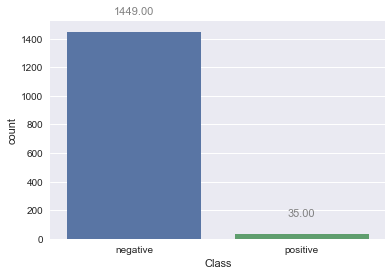

In [280]:
#load dataset
input=pd.read_csv("yeast6_data.dat", sep=',', header='infer')
#print(input)
#plot barcharts of different classes
ax = sns.countplot(x="Class", data=input)
#annotate 
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),textcoords='offset points')
counts=input['Class'].value_counts()
#print(counts)

Smote settings. The smote_ratio is set up high enough so that it will result in comparable number of smote minority points to the majority class points

In [282]:
#find the imbalance ratio
ratio=counts.negative/counts.positive
smote_ratio=int(ratio)
print('smote_ratio=',smote_ratio)
#nn number of nearest neighbours to use for smote data generation
nn=5
#plotflag=1 plot smote data  
plotflag=1
#how many folds for training/testing
nKfold=3

smote_ratio= 41


Separate the data into a number of folds using the StratifiedKFold so that the ratio of the classes will be preserved in all train/test folds

In [272]:
#separate dataset to Kfolds 
skf=StratifiedKFold(n_splits=nKfold,shuffle=True)
#separate data in input data X and response y 
X=input.loc[:,'Mcg':'Nuc']
y=input.loc[:,'Class']    

In [283]:
#initialise accuracies and True Positive ratio
accuracy1 = pd.Series()
accuracy2 = pd.Series()
TP1 = pd.Series()
TP2 = pd.Series()

Apply smote to each train fold then apply SVM classification to the train+smote data and measure accuracy and true positive ratio of the minority class on the test fold  

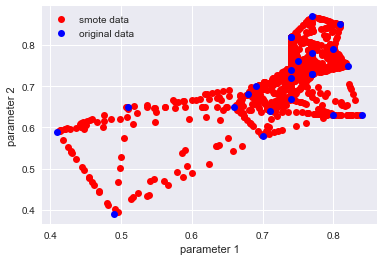

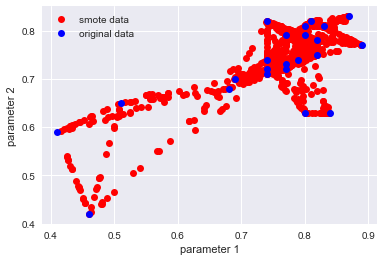

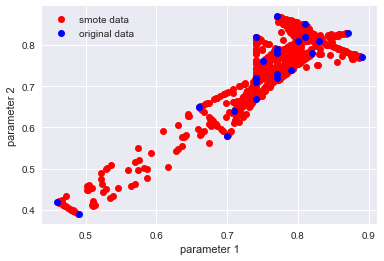

In [274]:
for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #apply svm on the train sample and calculate accuracy1 and TP1 on the test
        model = svm.SVC()
        model.fit(X_train, y_train) 
        # accuracy on test
        y_pred1=model.predict(X_test)
        accuracy1_temp=metrics.accuracy_score(y_test, y_pred1)
        cnf_matrix1 = metrics.confusion_matrix(y_test, y_pred1)
        #true positive ratio
        TP1_temp=cnf_matrix1[1,1]/(cnf_matrix1[1,0]+cnf_matrix1[1,1]) 
        #store accuracy and TP
        accuracy1=accuracy1.append(pd.Series(accuracy1_temp))
        TP1=TP1.append(pd.Series(TP1_temp),ignore_index=True)
        
        #apply smote on the train sample, only on the minority class data
        Xtrain_minority=X_train.loc[y_train=='positive',:]
        smotedata=mysmote(Xtrain_minority,nn,smote_ratio, plotflag)
        
        #Train+smotedata
        X_smote=X_train
        X_smote=X_smote.append(smotedata, ignore_index=True)
        #Ytrain+ysmote
        ytemp=['positive']*len(smotedata)
        ytemp = pd.Series(ytemp)
        ysmote=y_train.append(ytemp,ignore_index=True)
        # apply svm on the train+smote sample and calculate accuracy2 and TP2 on the test
        model = svm.SVC()
        model.fit(X_smote, ysmote) 
        # accuracy on test
        y_pred2=model.predict(X_test)
        accuracy2_temp=metrics.accuracy_score(y_test, y_pred2)
        cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
        #true positive ratio
        TP2_temp=cnf_matrix2[1,1]/(cnf_matrix2[1,0]+cnf_matrix2[1,1]) 
        #store accuracy and TP
        accuracy2=accuracy2.append(pd.Series(accuracy2_temp))
        TP2=TP2.append(pd.Series(TP2_temp),ignore_index=True)



In [275]:
#build a dataframe with all true psitive information to create a bar chart with seaborn
avgTP1=np.mean(TP1)
avgTP2=np.mean(TP2)
TP_all= pd.DataFrame(columns=['smote','TP value','Kfold'])
TP_all.loc[:,'smote']=['nosmote']*len(TP1)+['smote']*len(TP2)
TP_all.loc[0:len(TP1)-1,'Kfold']=np.arange(1,len(TP1)+1)
TP_all.loc[0:len(TP1)-1,'TP value']=TP1.values      
TP_all.loc[len(TP1):len(TP1)+len(TP2),'Kfold']=np.arange(1,len(TP2)+1)
TP_all.loc[len(TP1):len(TP1)+len(TP2),'TP value']=TP2.values
TP_all.loc['avg nosmote',:]=['nosmote',avgTP1,'average']   
TP_all.loc['avg smote',:]=['smote',avgTP2,'average'] 

The following bar chart shows that applying SVM on the Train data after adding smote generated minority class data, the minority class of the test samples gets classified more accuralely (i.e. True positive ratio increases). Note that this will happen when smote_ratio is high enough (i.e. the minority class gets comparable number of smote points to the majority class)

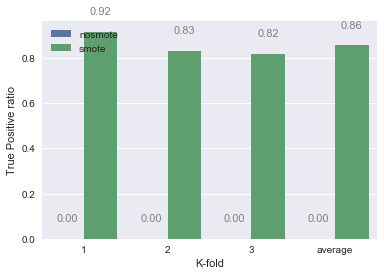

In [276]:
#plot TP
fig = sns.barplot(x="Kfold", y="TP value", hue="smote",data=TP_all,ci=None)
fig.set(xlabel='K-fold', ylabel='True Positive ratio')
#annotate 
for p in fig.patches:
             fig.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.legend(loc='upper left')
plt.show()